E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

E06: meta-exercise! Think of a fun/interesting exercise and complete it.
- n-gram model?

In [1]:
import torch
g = torch.Generator(device='cpu').manual_seed(2147483647)

In [2]:
words = open('names.txt').read().splitlines()

In [3]:
stoi = {s:i+1 for i, s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
bigram = torch.zeros((27, 27), dtype=torch.int16)
for w in words:
    chrs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chrs, chrs[1:]):
        bigram[stoi[c1], stoi[c2]] += 1

(-0.5, 26.5, 26.5, -0.5)

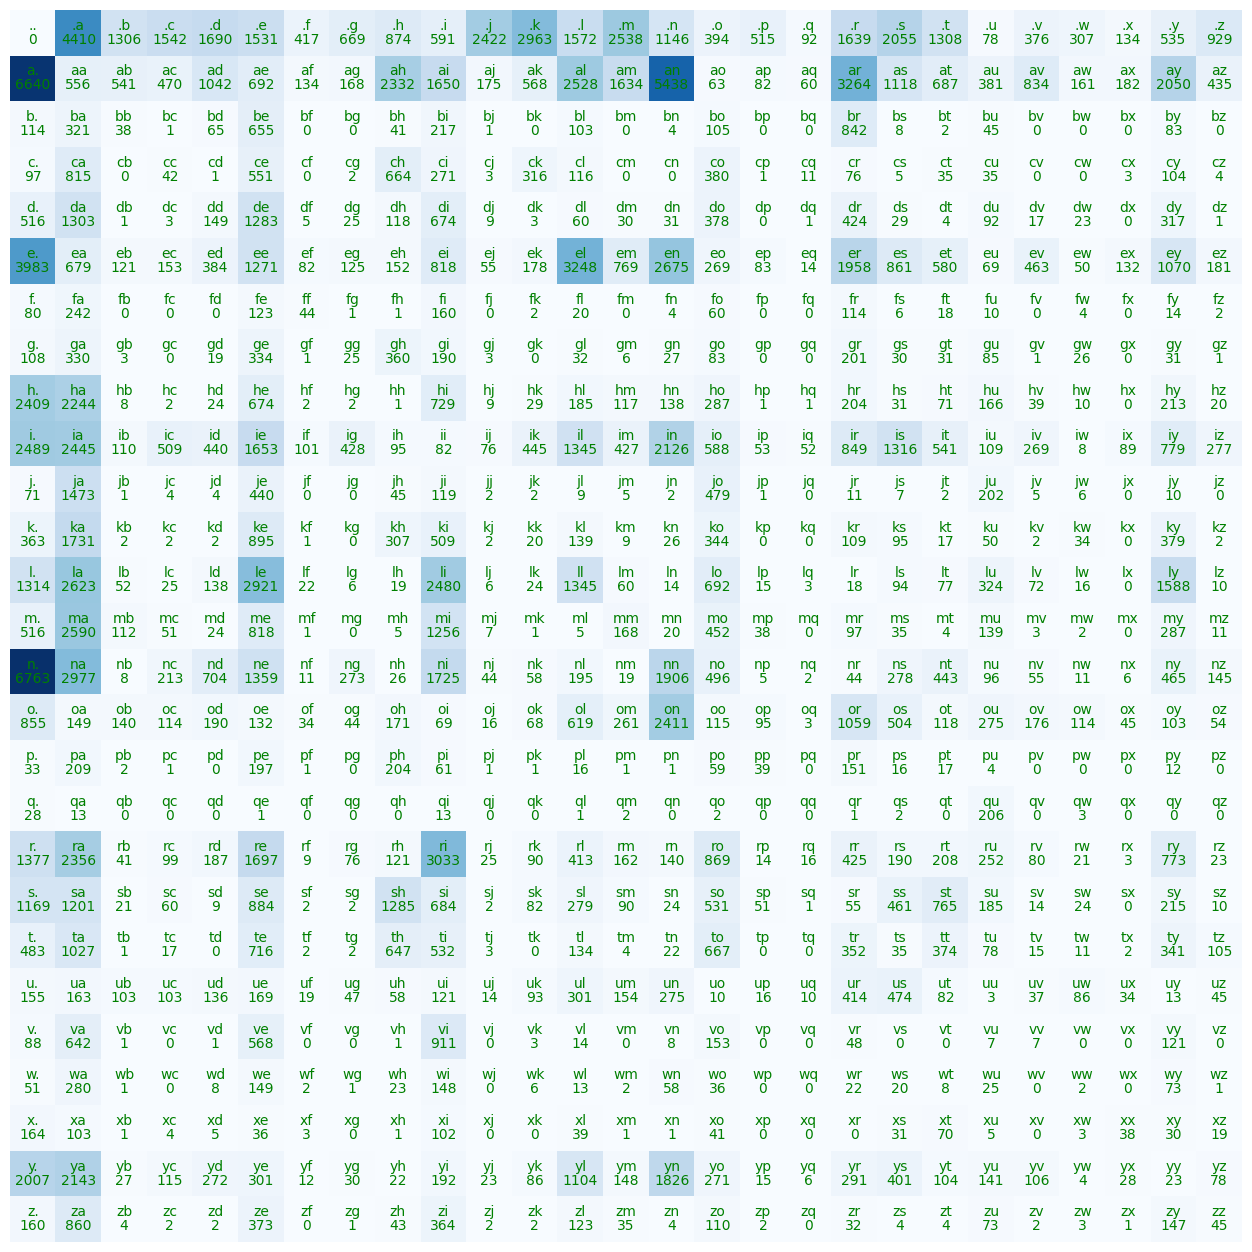

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(bigram, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='green')
        plt.text(j, i, bigram[i, j].item(), ha="center", va="top", color='green')
plt.axis('off')

In [6]:
P = (bigram+1).float() # Model smoothing; same as regularisation.
P /= P.sum(1, keepdim=True) # Broadcasting!

SAMPLES_COUNT = 10
samples = []
for _ in range(SAMPLES_COUNT):
    word = []
    ix = 0
    while True:
        ix = torch.multinomial(P[ix], 1, replacement=True, generator=g).item()
        word.append(itos[ix])
        if itos[ix] == '.': break
    samples.append(''.join(word))
print(samples)

['junide.', 'janasah.', 'p.', 'cony.', 'a.', 'nn.', 'kohin.', 'tolian.', 'juee.', 'ksahnaauranilevias.']


In [7]:
trigram = torch.zeros((27, 27, 27), dtype=torch.int16) # taking a risk here with int16; will convert to float later

for w in words:
    chrs = ['.'] + list(w) + ['.']

    for c1, c2, c3 in zip(chrs, chrs[1:], chrs[2:]): # Assuming every word is at least 1 letter long.
        trigram[stoi[c1], stoi[c2], stoi[c3]] += 1

∀ ix, trigram[ix]'s first row is always 0. This seems to be the only inefficiency.

(-0.5, 26.5, 26.5, -0.5)

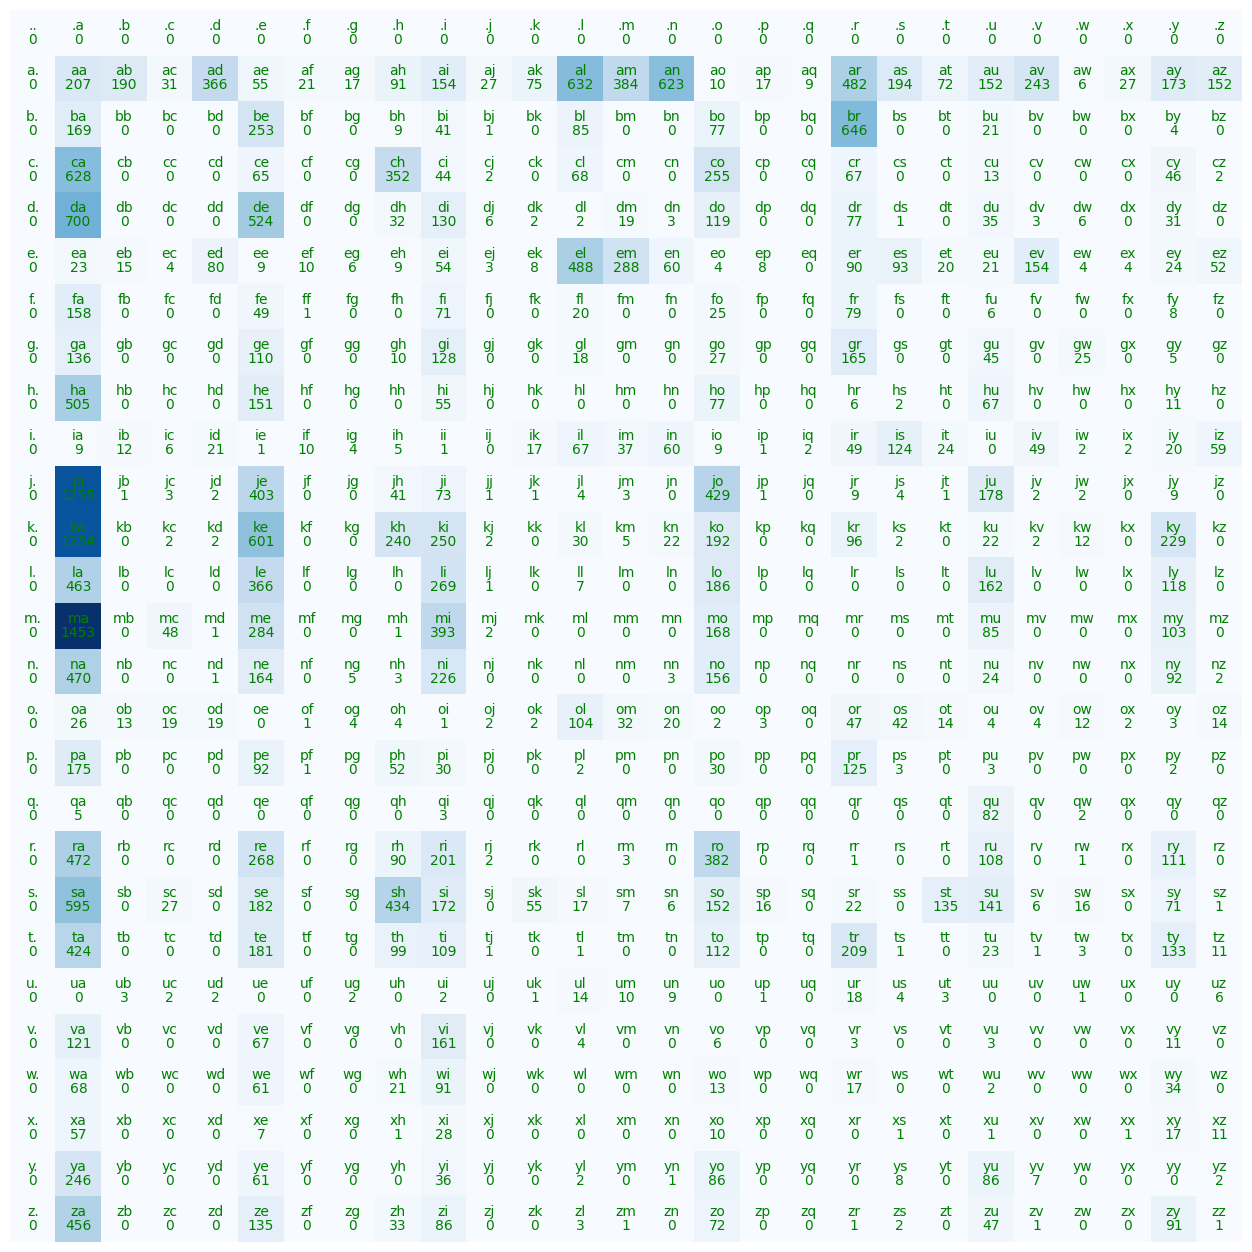

In [8]:
plt.figure(figsize=(16,16))
plt.imshow(trigram[0], cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='green')
        plt.text(j, i, trigram[0][i, j].item(), ha="center", va="top", color='green')
plt.axis('off')

In [9]:
next2 = trigram.float()
next2 /= next2.sum(dim=(1,2), keepdim=True) # P[ix][iy, iz] = P(iy, iz | ix) = P(ix, iy, iz) / P(ix)
assert(next2.sum() == torch.tensor(27.))

In [10]:
next1 = trigram.float()
next1 /= next1.sum(dim=2, keepdim=True)
next1.nan_to_num_()

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0469, 0.0431,  ..., 0.0061, 0.0392, 0.0345],
         [0.0000, 0.1294, 0.0000,  ..., 0.0000, 0.0031, 0.0000],
         ...,
         [0.0000, 0.4254, 0.0000,  ..., 0.0075, 0.1269, 0.0821],
         [0.0000, 0.4598, 0.0000,  ..., 0.0000, 0.0000, 0.0037],
         [0.0000, 0.4909, 0.0000,  ..., 0.0000, 0.0980, 0.0011]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0719, 0.0000, 0.0090,  ..., 0.0000, 0.0360, 0.0198],
         [0.0665, 0.0518, 0.0370,  ..., 0.0000, 0.0222, 0.0000],
         ...,
         [0.0604, 0.0275, 0.0000,  ..., 0.0934, 0.0330, 0.0165],
         [0.0795, 0.1898, 0.0063,  ..., 0.0000, 0.0078, 0.0195],
         [0.0874, 0.2828, 0.0000,  ..., 0.0000, 0.0276, 0.0506]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1433, 0.0156, 0.0156,  ..., 0.0125, 0.0966, 0.0125],
         [0.0263, 0.2105, 0.0000,  ..., 0.0000, 0.2368, 0.

In [11]:
SAMPLES_COUNT = 10
samples = []
for _ in range(SAMPLES_COUNT):
    ix = 0
    thing = torch.multinomial(next2[ix].view(-1), 1, replacement=True, generator=g).item() # flatten returns a copy
    iy, iz = divmod(thing, 27)
    word = [itos[iy], itos[iz]]
    while itos[iz] != '.':
        new = torch.multinomial(next1[iy, iz], 1, replacement=True, generator=g).item()
        iy, iz = iz, new
        word.append(itos[iz])
    samples.append(''.join(word))
print(samples)

['stedainewin.', 'yiassiyanayla.', 'raylindeumarif.', 'jatum.', 'akennashiah.', 'traylicore.', 'yahenocken.', 'go.', 'kliyandemikim.', 'denin.']


In [12]:
# GOAL: maximise likelihood of seeing the test data w.r.t. the model parameters we just trained a model on.
# ≡ maximise prod of prob ≡ maximise log of prod of prob ≡ minimise nll ≡ minimise average nll
nll = 0
n = 0
for w in words:
    chrs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chrs, chrs[1:]):
        n += 1
        nll += -torch.log(P[stoi[c1], stoi[c2]])
print(nll/n)

tensor(2.4544)


In [13]:
nll = 0
n = 0
for w in words:
    chrs = ['.'] + list(w) + ['.']
    for c1, c2, c3 in zip(chrs, chrs[1:], chrs[2:]):
        n += 1
        nll += -torch.log(next1[stoi[c1], stoi[c2], stoi[c3]])
        # using Bengio 2003 notation: P̂(wᵗ|wᵗ⁻¹₁) is the goal which we are approximating using
        # P̂(wᵗ|wᵗ⁻¹_{t-n+1}) where n = 3 for trigrams
print(nll/n)

tensor(2.0620)


# Neural Networks

In [14]:
Xs, ys = [], []
for w in words:
    chrs = ['.'] + list(w) + ['.']
    for c1, c2, c3 in zip(chrs, chrs[1:], chrs[2:]):
        Xs.append(stoi[c1]*27 + stoi[c2])
        ys.append(stoi[c3])

Xs = torch.tensor(Xs)
ys = torch.tensor(ys)

In [15]:
import torch.nn.functional as F
Xenc = F.one_hot(Xs, num_classes=27*27).float()

In [16]:
import math
W = torch.randn((729, 27), generator=g) * math.sqrt(2 / 729) # He initialisation
W.requires_grad_()
b = torch.zeros(27, requires_grad=True)

In [17]:
def softmax(logits):
    counts = logits.exp()
    return counts / counts.sum(1, keepdim=True) # Returns probabilities given log counts

In [18]:
# Training
epochs = 100
learning_rate = 10
L2 = 0.01
for epoch in range(epochs):
    # Forward pass
    logits = Xenc @ W + b
    probs = softmax(logits)
    loss = -probs[range(ys.shape[0]), ys].log().mean() + L2*(W**2).mean() # avg nll
    print(f'Loss before epoch {epoch}: {loss:.4f}')

    # Backward pass
    W.grad = None # apparently more efficient
    b.grad = None
    loss.backward()
    # Now every value of W.grad is telling the influence of that element on the final loss.

    # Update
    W.data -= learning_rate * W.grad # Without data, we get RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.
    b.data -= learning_rate * b.grad

Loss before epoch 0: 3.2980
Loss before epoch 1: 2.8880
Loss before epoch 2: 2.7818
Loss before epoch 3: 2.7394
Loss before epoch 4: 2.7144
Loss before epoch 5: 2.6968
Loss before epoch 6: 2.6830
Loss before epoch 7: 2.6715
Loss before epoch 8: 2.6614
Loss before epoch 9: 2.6524
Loss before epoch 10: 2.6441
Loss before epoch 11: 2.6364
Loss before epoch 12: 2.6291
Loss before epoch 13: 2.6223
Loss before epoch 14: 2.6158
Loss before epoch 15: 2.6096
Loss before epoch 16: 2.6036
Loss before epoch 17: 2.5979
Loss before epoch 18: 2.5924
Loss before epoch 19: 2.5871
Loss before epoch 20: 2.5820
Loss before epoch 21: 2.5770
Loss before epoch 22: 2.5722
Loss before epoch 23: 2.5675
Loss before epoch 24: 2.5629
Loss before epoch 25: 2.5585
Loss before epoch 26: 2.5542
Loss before epoch 27: 2.5500
Loss before epoch 28: 2.5459
Loss before epoch 29: 2.5420
Loss before epoch 30: 2.5381
Loss before epoch 31: 2.5343
Loss before epoch 32: 2.5306
Loss before epoch 33: 2.5270
Loss before epoch 34: 2.

In [19]:
# Sampling from neural net
examples_count = 10
examples = []
for _ in range(examples_count):
    word_generated = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=729).float()
        logits = xenc @ W + b
        probs = softmax(logits)
        ix = torch.multinomial(probs, 1, replacement=True, generator=g).item()
        word_generated.append(itos[ix])
        if itos[ix] == '.': break
    examples.append(''.join(word_generated))
print(examples)

['caau.', 'raruar.', 'ral.', 'rnananeoroanb.', 'ilalatmalaemyasvireyadayialamtanolvryeleialaeaharx.', 'rlonarneyyanrayo.', 'nnauiolie.', 'esniechvc.', 'nalairaaadahl.', 'hieanrv.']
